In [5]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from IPython.display import Image, display
from dotenv import load_dotenv
from catboost import CatBoostClassifier

from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage

# Add parent dir
sys.path.append('..')
load_dotenv('../.env')

from agent.state import XAIState
from agent.nodes.data_understanding import get_dataset_samples, update_metadata, data_understanding_agent
from agent.nodes.global_explainer import global_explainer_agent, get_global_feature_importance_shap
from agent.nodes.local_explainer import local_explainer_agent, run_lime_explanation, run_shap_explanation
from agent.nodes.router import router_agent

In [6]:
# 1. Load Data (Custom ARFF Loader)
def load_arff_data(file_path):
    data = []
    columns = []
    with open(file_path, 'r') as f:
        data_started = False
        for line in f:
            line = line.strip()
            if not line: continue
            if line.lower().startswith("@attribute"):
                parts = line.split()
                columns.append(parts[1])
            elif line.lower().startswith("@data"):
                data_started = True
                continue
            elif data_started:
                row = [x.strip().strip("'").strip('"') for x in line.split(',')]
                data.append(row)
    return pd.DataFrame(data, columns=columns)

dataset_path = "../datasets/banking_deposit_subscription/dataset"
df = load_arff_data(dataset_path)

for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
       pass 

# 2. Load Model
model = CatBoostClassifier()
model.load_model("../notebooks/models/catboost_model.cbm")

print("Loaded Data and Model.")

Loaded Data and Model.


In [ ]:
tools_data_understanding = [get_dataset_samples, update_metadata]
tool_node_data_understanding = ToolNode(tools_data_understanding)

tools_global_explainer = [get_global_feature_importance_shap]
tool_node_global_explainer = ToolNode(tools_global_explainer)

tools_local_explainer = [run_shap_explanation, run_lime_explanation]
tool_node_local_explainer = ToolNode(tools_local_explainer)

graph = StateGraph(XAIState)

graph.add_node("data_understanding_agent", data_understanding_agent)
graph.add_node("tools", tool_node_data_understanding)

graph.add_node("router_agent", router_agent)

graph.add_node("global_explainer_agent", global_explainer_agent)
graph.add_node("tools_global_explainer", tool_node_global_explainer)

graph.add_node("local_explainer_agent", local_explainer_agent)
graph.add_node("tools_local_explainer", tool_node_local_explainer)

graph.set_entry_point("data_understanding_agent")
graph.add_conditional_edges("data_understanding_agent", tools_condition, {"tools": tool_node_data_understanding, "else": router_agent})
graph.add_conditional_edges("router_agent", router_condition, {"global_explainer": "global_explainer_agent", "local_explainer": "local_explainer_agent"})

graph.add_conditional_edges("global_explainer_agent", tools_global_explainer_condition, {"tools_global_explainer": tool_node_global_explainer})
graph.add_conditional_edges("local_explainer_agent", tools_local_explainer_condition, {"tools_local_explainer": tool_node_local_explainer})


app = graph.compile()

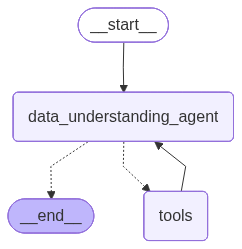

In [4]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
initial_state = {
    "df": df,
    "model": model,
    "messages": [HumanMessage(content="Please tell me something about the dataset and its features.")]
}

result = app.invoke(initial_state)

In [7]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Please tell me something about the dataset and its features.
================================== Ai Message ==================================
Tool Calls:
  get_dataset_samples (call_0U7arLb9Q0u6YRGcG1wH2NGK)
 Call ID: call_0U7arLb9Q0u6YRGcG1wH2NGK
  Args:
================================= Tool Message =================================
Name: get_dataset_samples

--- Samples ---
   age           job   marital  education default  balance housing loan  contact  day month  duration  campaign  pdays  previous poutcome   y
0   58    management   married   tertiary      no     2143     yes   no  unknown    5   may       261         1     -1         0  unknown  no
1   44    technician    single  secondary      no       29     yes   no  unknown    5   may       151         1     -1         0  unknown  no
2   33  entrepreneur   married  secondary      no        2     yes  yes  unknown    5   may        76         1 